### NLP 프로젝트 [2조. TypeError줄까... ShapeError줄까...]
### 괴담 탐색 모델 (RNN) 만들기

*괴담 국적 분류 모델*
- [1] 데이터 준비
- [2] 데이터 전처리
    - (한글 제외 모두 제거, 줄임말 한 가지로 처리) ~ skip
    - 토큰화
    - 토큰 데이터 정수 인코딩, 데이터 길이 표준화(패딩)
- [3] 학습 준비
    - Dataset, DataLoader 준비
    - 모델 클래스
    - 학습, 테스트 함수
    - 학습 관련 변수 => DEVICE, OPTIMIZER, MODEL 인스턴스, EPOCHS, BATCH_SIZE, LOSS_FN

[1] 데이터 준비

In [1]:
### 데이터셋 읽기 (모든 시트를 읽어온다.)
import pandas as pd

sheet_names = []    # 시트이름 저장

with pd.ExcelFile('horror_comedy.xlsx') as xls:
    sheet_names = xls.sheet_names
    
    horrorDict = {}
    for sheet_name in xls.sheet_names:
        # 각 시트의 2번째 행을 컬럼으로 설정하여 DataFrame으로 읽어온다.
        df = pd.read_excel(xls, sheet_name=sheet_name, header=1)
        horrorDict[sheet_name] = df

In [2]:
sheet_names

['BJY', 'LHG_Neapolitan', 'LHG_Horror', 'SY', 'why']

In [3]:
for i, (k, v) in enumerate(horrorDict.items()):
    print(f'k : {k}')
    print(f'v : {type(v)}')

k : BJY
v : <class 'pandas.core.frame.DataFrame'>
k : LHG_Neapolitan
v : <class 'pandas.core.frame.DataFrame'>
k : LHG_Horror
v : <class 'pandas.core.frame.DataFrame'>
k : SY
v : <class 'pandas.core.frame.DataFrame'>
k : why
v : <class 'pandas.core.frame.DataFrame'>


In [4]:
# '괴담'에 해당하는 DataFrame만 저장
horrorDFs = []

for i in range(4):
    horrorDFs.append(horrorDict[sheet_names[i]])

print(len(horrorDFs))

4


In [5]:
# '괴담'에 해당하는 DataFrame들의 컬럼명 확인
for i in range(4):
    print(horrorDFs[i].columns)

Index(['CLASS', 'TYPE', 'FROM', 'TEXT'], dtype='object')
Index(['CLASS', 'TYPE', 'FROM', 'TEXT'], dtype='object')
Index(['CLASS', 'TYPE', 'FROM', 'TEXT'], dtype='object')
Index(['CLASS', 'TYPE', 'FROM', 'TEXT'], dtype='object')


In [6]:
### '괴담'에 해당하는 DataFrame 들을 하나로 합치기
# 세로 방향으로 DataFrame 합치키
horrorDF = pd.concat(horrorDFs, axis=0)

# 합쳐진 DataFrame 확인
print(horrorDF.info())

<class 'pandas.core.frame.DataFrame'>
Index: 3200 entries, 0 to 998
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   CLASS   3200 non-null   object
 1   TYPE    3200 non-null   object
 2   FROM    3200 non-null   object
 3   TEXT    3200 non-null   object
dtypes: object(4)
memory usage: 125.0+ KB
None


In [7]:
### horrorDF 컬럼 구성요소 확인
for col in horrorDF.columns:
    print(horrorDF[col].nunique())

1
2
3
3161


In [8]:
# 'CLASS' 컬럼의 구성요소 확인
print(horrorDF['CLASS'].unique())

# 'CLASS' 컬럼은 'H' 로만 이루어져 있으므로 삭제
horrorDF.drop(columns=['CLASS'], inplace=True)

# horrorDF 정보 출력
horrorDF.info()

['H']
<class 'pandas.core.frame.DataFrame'>
Index: 3200 entries, 0 to 998
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   TYPE    3200 non-null   object
 1   FROM    3200 non-null   object
 2   TEXT    3200 non-null   object
dtypes: object(3)
memory usage: 100.0+ KB


In [9]:
print(horrorDF.index)

Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
       ...
       989, 990, 991, 992, 993, 994, 995, 996, 997, 998],
      dtype='int64', length=3200)


In [10]:
# 인덱스가 중복되는 것을 확인
print(horrorDF.loc[0])

# 인덱스를 RangeIndex로 초기화
horrorDF.reset_index(drop=True, inplace=True)

# 잘 초기화되었는지 확인
print(horrorDF.index)

  TYPE FROM                                               TEXT
0    E    K  "그런데 어떻게 알았어?" 이렇게 묻더라구요, 저는 뭐가? 라고 대답하니 "꿈인줄 ...
0    G    W                      - 마을에 있는 모든 간판과 게시판에 주의를 기울여.
0    E    J  " 병원에 오랫동안 입원 중이셨던 시어머니가 돌아가시고 시동생 부부와 저 그리고 남...
0    E    K  오늘 학교에서 모의고사보는데 가위눌리다가 한쪽눈만 떠진상태로 교실에서 내 다리에 올...
RangeIndex(start=0, stop=3200, step=1)


In [11]:
### 괴담의 국가별 비중 확인
### 한국 : 일본 : 영미권 = 1500 : 1000 : 700
horrorDF['FROM'].value_counts()

FROM
K    1539
J     965
W     696
Name: count, dtype: int64

[2] 데이터 전처리

In [12]:
### 불용어 다운로드
from urllib.request import urlretrieve

hangule_stopword = "https://gist.githubusercontent.com/chulgil/d10b18575a73778da4bc83853385465c/raw/a1a451421097fa9a93179cb1f1f0dc392f1f9da9/stopwords.txt"
urlretrieve(hangule_stopword, "./stopwords.txt")

('./stopwords.txt', <http.client.HTTPMessage at 0x1d52e692dc0>)

In [13]:
from soynlp.normalizer import *

repeat_normalize('ㄷㄷㄷㄷ', num_repeats=2)

'ㄷㄷ'

In [14]:
from soynlp.normalizer import *

def kor_nlp_preprocessing(inputSR):
    """
    한국어 NLP 전처리 (결측치 제거, 한글과 공백만 남김, 한글 줄임말 제거)
    :param inputSR: 한국어 문장으로 구성된 pandas Series 객체
    :return: 전처리가 끝난 pandas Series 객체
    """
    
    if not isinstance(inputSR, pd.Series):
        print('Series 객체가 아님')
        return False
    
    ### 결측치 제거
    inputSR = inputSR.dropna()
    
    ### 한글과 공백만 남김
    inputSR = inputSR.str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", '', regex=True)
    
    ### 한글 줄임말 정규화
    inputSR= inputSR.apply(repeat_normalize, num_repeats=2)
    
    return inputSR

In [15]:
horrorDF['TEXT2'] = kor_nlp_preprocessing(horrorDF['TEXT'])

In [16]:
### 토크나이저 생성
from konlpy.tag import Okt
tokenizer = Okt()

In [17]:
### 토큰화 (전체 문장)
total_tokens = [tokenizer.morphs(text, stem=True) for text in horrorDF['TEXT2']]

In [18]:
### 문장 당 토큰 개수 (전체 문장)
total_token_counts = [len(tokens) for tokens in total_tokens]

In [19]:
### 숫자들의 등장 횟수 세기
from collections import Counter

counter = Counter(total_token_counts)
print(counter)

Counter({38: 60, 56: 55, 51: 54, 41: 54, 42: 53, 53: 53, 57: 51, 50: 51, 40: 51, 47: 49, 60: 48, 28: 48, 33: 48, 29: 48, 52: 47, 48: 47, 65: 46, 71: 46, 30: 46, 44: 46, 37: 45, 43: 45, 54: 44, 32: 44, 25: 43, 35: 42, 64: 42, 70: 41, 58: 41, 34: 41, 31: 41, 45: 41, 63: 41, 46: 40, 66: 39, 23: 39, 62: 38, 49: 38, 36: 38, 39: 38, 69: 37, 68: 37, 24: 37, 61: 37, 59: 37, 73: 37, 74: 36, 55: 35, 26: 35, 72: 33, 67: 33, 20: 33, 79: 32, 27: 32, 22: 32, 15: 31, 80: 30, 76: 29, 87: 27, 77: 26, 78: 26, 83: 25, 75: 25, 81: 22, 21: 22, 85: 20, 82: 20, 19: 20, 86: 19, 17: 19, 14: 19, 12: 19, 95: 18, 88: 18, 11: 18, 18: 18, 84: 17, 91: 16, 93: 14, 16: 14, 92: 14, 102: 13, 94: 13, 9: 12, 90: 11, 13: 11, 97: 11, 10: 11, 8: 10, 109: 10, 98: 9, 99: 9, 96: 9, 108: 8, 103: 8, 89: 8, 7: 8, 100: 7, 112: 7, 121: 6, 6: 6, 106: 6, 105: 6, 101: 5, 3: 5, 104: 4, 122: 4, 110: 4, 127: 3, 126: 3, 113: 3, 116: 3, 5: 3, 111: 3, 125: 3, 145: 3, 114: 3, 115: 3, 107: 3, 117: 2, 134: 2, 135: 2, 120: 2, 119: 2, 153: 2, 2: 

In [20]:
# 문장당 가장 많이 나왔던 토큰 수 Top 5
counter.most_common(5)

[(38, 60), (56, 55), (51, 54), (41, 54), (42, 53)]

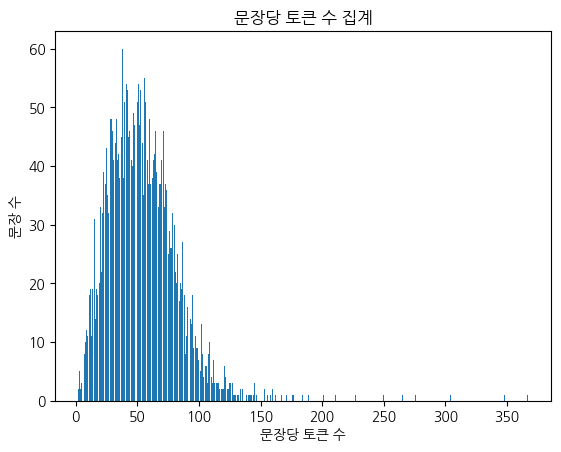

In [21]:
### 패딩할 문장 길이 알아보기 -> 50개로 결정 (이상적: 64개)
import matplotlib.pyplot as plt
import koreanize_matplotlib

x_values = list(counter.keys())
y_values = list(counter.values())

plt.bar(x_values, y_values)
plt.title('문장당 토큰 수 집계')
plt.xlabel('문장당 토큰 수')
plt.ylabel('문장 수')
plt.show()

단어사전 생성 (1) - Okt 토크나이저 사용 (학습 : horror 데이터셋)

In [22]:
### 토큰 제너레이터 함수 : 데이터 추출하여 토큰화
def yield_tokens(tokenizer, data_iter):
    for _, text in data_iter:
        # 라벨, 텍스트 -> 텍스트 토큰화
        yield tokenizer.morphs(text)

In [23]:
### 훈련용, 테스트용 데이터셋으로 나누기 (DataFrame.sample)
trainDF = horrorDF.sample(frac=0.9, random_state=42)   # DF
testDF = horrorDF.drop(trainDF.index)                  # DF

In [24]:
trainDF.shape, testDF.shape

((2880, 4), (320, 4))

In [25]:
# 단어 사전 생성
from torchtext.vocab import build_vocab_from_iterator

train_text = trainDF['TEXT2']
train_iter = train_text.items()     # zip 객체 (제너레이터)

In [26]:
vocab = build_vocab_from_iterator(yield_tokens(tokenizer, train_iter), min_freq=2, specials=['<PAD>', '<UNK>'])
# min_freq : 최소 n번 나와야 사전에 등록할 지 정함, n=1이 기본값, n이 커지면 사전에 등재되는 단어의 수도 적어진다
# specials : 사전에 등재할 특수 토큰을 지정할 수 있다. 기본값은 ["<unk>", "<pad>", "<bos>", "<eos>", "<mask>"]이다

In [27]:
vocab.set_default_index(vocab["<UNK>"])

In [28]:
len(vocab.get_itos())   # 단어사전의 크기

9053

In [29]:
tokenizer.morphs('내가초등학교2학년때일이야')

['내', '가', '초등학교', '2', '학년', '때', '일이', '야']

In [30]:
vocab(tokenizer.morphs('내가초등학교2학년때일이야'))

[19, 5, 708, 1, 609, 22, 107, 135]

단어사전 생성 (2) - MaxScoreTokenizer 사용 (학습 : news_data 데이터셋)

In [31]:
from soynlp.word import WordExtractor       # 단어 추출
from soynlp.tokenizer import MaxScoreTokenizer
from soynlp import DoublespaceLineCorpus    # 한 개로 통합된 문서 데이터 분리

filename = './news_data.txt'
corpus = DoublespaceLineCorpus(filename)
print(f'훈련 데이터 문서 : {len(corpus)}개')

### soynlp 학습 진행
word_extractor = WordExtractor()

# 학습 진행하며 단어별 점수 생성
word_extractor.train(corpus)

# 단어별 점수표 추출
word_score_table = word_extractor.extract()

scores = {word:score.cohesion_forward for word, score in word_score_table.items()}

maxscore_tokenizer = MaxScoreTokenizer(scores=scores)
print(maxscore_tokenizer.tokenize('국제사회와 우리의노력들로 범죄를척결하자'
                            # , flatten=False
                            ))

훈련 데이터 문서 : 30091개
training was done. used memory 1.409 Gb
all cohesion probabilities was computed. # words = 223348
all branching entropies was computed # words = 361598
all accessor variety was computed # words = 361598
['국제사회', '와', '우리', '의', '노력', '들로', '범죄', '를', '척결', '하자']


In [32]:
### 토큰 제너레이터 함수 : 데이터 추출하여 토큰화
def yield_tokens2(tokenizer, data_iter):
    for _, text in data_iter:
        # 라벨, 텍스트 -> 텍스트 토큰화
        yield tokenizer.tokenize(text)

In [33]:
vocab2 = build_vocab_from_iterator(yield_tokens2(maxscore_tokenizer, train_iter), min_freq=2, specials=['<PAD>', '<UNK>'])

In [34]:
vocab2.set_default_index(vocab2["<UNK>"])

In [35]:
len(vocab2.get_itos())

2

In [36]:
maxscore_tokenizer.tokenize('내가초등학교2학년때일이야')

['내가', '초등학교', '2학년때', '일이', '야']

In [37]:
vocab2(maxscore_tokenizer.tokenize('내가 초등학교 2학년 때 일이야'))

[1, 1, 1, 1, 1, 1]

In [38]:
print(f'[VOCAB] -> {len(vocab)}개\n')
print(vocab.get_itos()[:10])

[VOCAB] -> 9053개

['<PAD>', '<UNK>', '이', '을', '에', '가', '를', '의', '는', '그']


[3] 데이터 가공
- 토큰 데이터 정수 인코딩
- 데이터 길이 표준화 => 데이터의 길이 맞추기(1개 문장 구성하는 단어 수 통일)

In [39]:
### 훈련용, 테스트용 데이터셋으로 나누기 (DataFrame.sample)
trainDF = horrorDF.sample(frac=0.9, random_state=42)   # DF
testDF = horrorDF.drop(trainDF.index)                  # DF

In [40]:
trainDF.shape, testDF.shape

((2880, 4), (320, 4))

In [41]:
### 문장들을 단어 단위로 분리 (stem : 어근 처리)
train_tokens = [tokenizer.morphs(text, stem=True) for text in trainDF['TEXT2']]
test_tokens = [tokenizer.morphs(text, stem=True) for text in testDF['TEXT2']]

In [42]:
### 인코딩 : 문자 >>> 숫자로 변환
token_to_id = vocab.get_stoi()  # Dict

### 디코딩 : 숫자 >>> 문자로 변환
id_to_token = vocab.get_itos()  # List

In [43]:
### 단어를 정수로 변환 (단어/어휘 사전에 없는 문자는 <UNK>에 대응하는 숫자[1]로 처리)
UNK_ID = token_to_id["<UNK>"]   # 1
train_ids = [[token_to_id.get(token, UNK_ID) for token in text] for text in train_tokens]
test_ids = [[token_to_id.get(token, UNK_ID) for token in text] for text in test_tokens]

[3-2] 데이터 구성 단어 수 맞추기 즉, 패딩(padding)
- 단어 수 선정 필요
- 선정된 단어 수에 맞게 데이터 조절 => 길면 잘라내기, 짧으면 채우기

In [44]:
### 패딩 처리 함수
def pad_sequence(sentences, max_length, pad, start='R'):    # start : padding이 붙는 방향
    result = []
    for sen in sentences:
        sen = sen[:max_length] if start == 'R' else sen[-1 * max_length:]
        pad_length = max_length - len(sen)  # sen이 원래 max_length 보다 짧았다면 1이상의 값 저장
        padd_sen = sen + [pad]*pad_length if start == 'R' else [pad]*pad_length + sen
        result.append(padd_sen)
    return result

In [45]:
### 학습용, 테스트용 데이터 패딩 처리
PAD_ID = token_to_id.get('<PAD>')
MAX_LENGTH = 64     # 패딩 길이. 데이터를 분석해서 결정해야 한다.

train_ids = pad_sequence(train_ids, MAX_LENGTH, PAD_ID)     # 일정한 길이의 정수 인코딩 데이터
test_ids = pad_sequence(test_ids, MAX_LENGTH, PAD_ID)       # 일정한 길이의 정수 인코딩 데이터

In [46]:
print(f'[train_ids] -> {len(train_ids[1])}개')
print(f'[test_ids] -> {len(test_ids[1])}개')

[train_ids] -> 64개
[test_ids] -> 64개


In [47]:
print(train_ids[1])
print(test_ids[1])

[183, 5, 2, 8442, 6, 72, 216, 1, 1979, 2254, 2, 199, 2644, 13, 902, 69, 2, 1196, 566, 4, 338, 3661, 902, 67, 12, 1, 107, 1, 4552, 2608, 6239, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[53, 9, 278, 9026, 4, 120, 1876, 46, 4, 4172, 39, 12, 1, 1979, 153, 1, 7326, 2, 1, 39, 12, 1, 136, 274, 133, 14, 4603, 411, 46, 12, 46, 14, 1, 1979, 144, 1014, 23, 465, 1, 1, 120, 46, 12, 93, 128, 1036, 120, 430, 1, 17, 1, 274, 5, 8901, 12, 93, 128, 1036, 120, 47, 8, 528, 465, 3193]


[4] 학습 준비
- Dataset, DataLoader 준비
- 학습용/테스트용 함수
- 모델 클래스
- 학습 관련 변수 => DEVICE, OPTIMIZER, MODEL 인스턴스, EPOCHS, BATCH_SIZE, LOSS_FN

In [48]:
from sklearn.preprocessing import LabelEncoder

# LabelEncoder 객체 생성
label_encoder = LabelEncoder()

# 문자열 Series를 숫자 Series로 변환
train_labels = label_encoder.fit_transform(trainDF['FROM'])
test_labels = label_encoder.fit_transform(testDF['FROM'])

In [49]:
label_encoder.classes_

array(['J', 'K', 'W'], dtype=object)

In [50]:
import torch
from torch.utils.data import TensorDataset, DataLoader

In [51]:
### 데이터셋 생성 : List >>> Tensor
print(type(train_ids), type(trainDF.FROM.values))

dataTS1 = torch.LongTensor(train_ids)   # 임베딩에 들어가는 것은 Long, Int
labelTS1 = torch.LongTensor(train_labels)
dataTS2 = torch.LongTensor(test_ids)    # 임베딩에 들어가는 것은 Long, Int
labelTS2 = torch.LongTensor(test_labels)

print(dataTS1.shape, labelTS1.shape)
print(dataTS2.shape, labelTS2.shape)

# 데이터셋 생성
trainDS = TensorDataset(dataTS1, labelTS1)
testDS = TensorDataset(dataTS2, labelTS2)

<class 'list'> <class 'numpy.ndarray'>
torch.Size([2880, 64]) torch.Size([2880])
torch.Size([320, 64]) torch.Size([320])


In [52]:
### 데이터로더 생성
BATCH_SIZE = 32

trainDL = DataLoader(trainDS, BATCH_SIZE, shuffle=True)
testDL = DataLoader(testDS, BATCH_SIZE, shuffle=True)

In [53]:
for texts, labels in trainDL:
    print(texts)
    print(labels)
    print(texts.shape, labels.shape)
    break

tensor([[3032, 5149,   10,  ...,    0,    0,    0],
        [ 153, 2916,    2,  ...,    0,    0,    0],
        [  57, 2238,   16,  ...,    0,    0,    0],
        ...,
        [ 247,    2,  572,  ...,    0,    0,    0],
        [ 462,  274,    8,  ...,    0,    0,    0],
        [4474,    7,    9,  ...,    0,    0,    0]])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 2, 0, 2, 0, 0, 1, 2, 0, 1,
        1, 1, 1, 1, 0, 2, 1, 2])
torch.Size([32, 64]) torch.Size([32])


[4-2] 모델 클래스 정의
- 입력층 : Embedding Layer
- 은닉층 : RNN/LSTM Layer
- 은닉층 : Dropout Layer
- 출력층 : Linear Layer

In [54]:
from torch import nn

class SentenceClassifier(nn.Module):
    
    def __init__(
            self,
            vocab_size,
            hidden_dim,
            embedding_dim,
            n_layers,
            dropout=0.5,
            bidirectional=True,
            model_type='lstm'
    ):
        super().__init__()

        self.embedding = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embedding_dim,
            padding_idx=0
        )

        if model_type == 'rnn':
            self.model = nn.RNN(
                input_size=embedding_dim,
                hidden_size=hidden_dim,
                num_layers=n_layers,
                bidirectional=bidirectional,
                dropout=dropout,
                batch_first=True,
            )
        elif model_type == 'lstm':
            self.model = nn.LSTM(
                input_size=embedding_dim,
                hidden_size=hidden_dim,
                num_layers=n_layers,
                bidirectional=bidirectional,
                dropout=dropout,
                batch_first=True,
            )
        
        self.classifier = nn.Linear(hidden_dim * 2, 3) if bidirectional else nn.Linear(hidden_dim, 3)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, inputs):
        embeddings = self.embedding(inputs)
        output, _ = self.model(embeddings)
        last_output = output[:, -1, :]
        last_output = self.dropout(last_output)
        logits = self.classifier(last_output)
        return logits

In [55]:
### DEVICE, CLASSIFIER, CRITERION, OPTIMIZER
from torch import optim

vocab_size = len(token_to_id)
hidden_dim = 64
embedding_dim = 128             # 임베딩 차원
n_layers = 2

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
CLASSIFIER = SentenceClassifier(
    vocab_size=vocab_size, hidden_dim=hidden_dim, embedding_dim=embedding_dim, n_layers=n_layers
)
# CRITERION = nn.BCEWithLogitsLoss().to(DEVICE)     # 이진분류용
CRITERION = nn.CrossEntropyLoss().to(DEVICE)
OPTIMIZER = optim.RMSprop(CLASSIFIER.parameters(), lr=0.001)
# OPTIMIZER = optim.Adam(CLASSIFIER.parameters())
# OPTIMIZER = optim.SGD(CLASSIFIER.parameters(), lr=0.01)

In [56]:
### 학습 중 모델 저장 관련 변수
import os

dir = './model/'
filename = dir + 'best_model.pth'

if not os.path.exists(dir):
    os.mkdir(dir)

In [57]:
import numpy as np
import torchmetrics.functional as metrics

def train(model, datasets, criterion, optimizer, device, interval):
    model.train()       # 학습 모드 ON
    losses = list()     # []
    accs = list()       # []


    for step, (input_ids, labels) in enumerate(datasets):
        input_ids = input_ids.to(device)
        # labels = labels.to(device).unsqueeze(1)
        
        logits = model(input_ids)
        loss = criterion(logits, labels)
        losses.append(loss.item())

        # 성능 평가
        pred_labels = logits.argmax(1)
        acc = metrics.accuracy(pred_labels, labels, task='multiclass', num_classes=3)
        accs.append(acc)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # if step % interval == 0:
            #print(f'Train Loss {step} : {np.mean(losses)}')
            # print(f'logit 값 : {len(logits)}, 실제 정답 : {len(labels)}')
        
        if not step%10: print('.', end='')
    
    print(f'\nTrain Loss : {np.mean(losses):.14f}, Train Accuracy : {np.mean(accs)}')
    # print(f'\n[ Train ] Loss ==> {np.mean(losses):.14f}')
    # print(f'[ Train ] Acc ==> {np.mean(accs):.14f}')
    return np.mean(losses), np.mean(accs)

In [58]:
def test(model, datasets, criterion, device):
    model.eval()    # 테스트 모드 ON
    losses = list() # []
    corrects = list()
    total_acc, total_count = 0,0

    for step, (input_ids, labels) in enumerate(datasets):
        input_ids = input_ids.to(device)
        # labels = labels.to(device).unsqueeze(1)

        logits = model(input_ids)
        loss = criterion(logits, labels)
        losses.append(loss.item())
        # yhat = torch.sigmoid(logits) > 0.5
        # corrects.extend(torch.eq(yhat, labels).cpu().tolist())
        total_acc += (logits.argmax(1) == labels).sum().item()
        total_count += labels.size(0)
    
    # print(f'Val Loss : {np.mean(losses)}, Val Accuracy : {np.mean(corrects)}')
    print(f'Val Loss : {np.mean(losses)}, Val Accuracy : {total_acc/total_count}')
    return np.mean(losses), total_acc/total_count

In [59]:
EPOCHS = 100
interval = 500
train_loss, train_acc = [], []
valid_loss, valid_acc = [], []

for epoch in range(EPOCHS):
    print(f'[EPOCH {epoch+1}]', end=' ')
    tr_loss, tr_acc = train(CLASSIFIER, trainDL, CRITERION, OPTIMIZER, DEVICE, interval)
    val_loss, val_acc = test(CLASSIFIER, testDL, CRITERION, DEVICE)

    train_loss.append(tr_loss)
    train_acc.append(tr_acc)
    valid_loss.append(val_loss)
    valid_acc.append(val_acc)

print("Done!")

[EPOCH 1] .........
Train Loss : 0.90875685148769, Train Accuracy : 0.5392361283302307
Val Loss : 0.8722127676010132, Val Accuracy : 0.578125
[EPOCH 2] .........
Train Loss : 0.83029259906875, Train Accuracy : 0.6111111044883728
Val Loss : 0.8050983190536499, Val Accuracy : 0.621875
[EPOCH 3] .........
Train Loss : 0.73620104789734, Train Accuracy : 0.6552083492279053
Val Loss : 0.7934063076972961, Val Accuracy : 0.64375
[EPOCH 4] .........
Train Loss : 0.64556944138474, Train Accuracy : 0.7013888955116272
Val Loss : 0.7034563422203064, Val Accuracy : 0.734375
[EPOCH 5] .........
Train Loss : 0.55600781275166, Train Accuracy : 0.7670139074325562
Val Loss : 0.7545588552951813, Val Accuracy : 0.721875
[EPOCH 6] .........
Train Loss : 0.46902784556150, Train Accuracy : 0.8138889074325562
Val Loss : 0.742962795495987, Val Accuracy : 0.709375
[EPOCH 7] .........
Train Loss : 0.43631859852208, Train Accuracy : 0.8368055820465088
Val Loss : 0.7191297084093093, Val Accuracy : 0.771875
[EPOCH 8

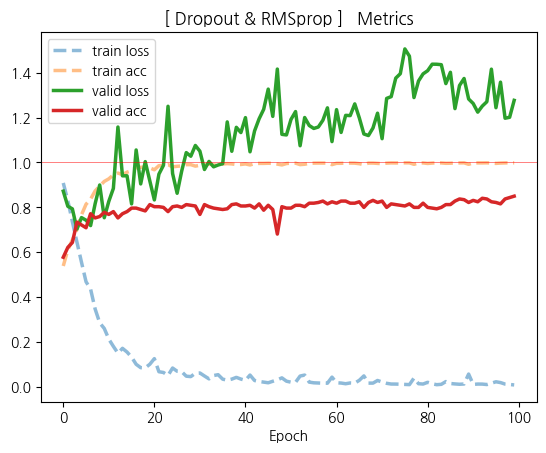

In [73]:
plt.plot(train_loss, label='train loss', linestyle='--', linewidth=2.5, alpha=0.5)
plt.plot(train_acc, label='train acc', linestyle='--', linewidth=2.5, alpha=0.5)
plt.plot(valid_loss, label='valid loss', linewidth=2.5)
plt.plot(valid_acc, label='valid acc', linewidth=2.5)

plt.axhline(y=1, linewidth=0.5, color='r', alpha=0.7)

plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.title('[ Dropout & RMSprop ]\t\t\tMetrics')
plt.show()

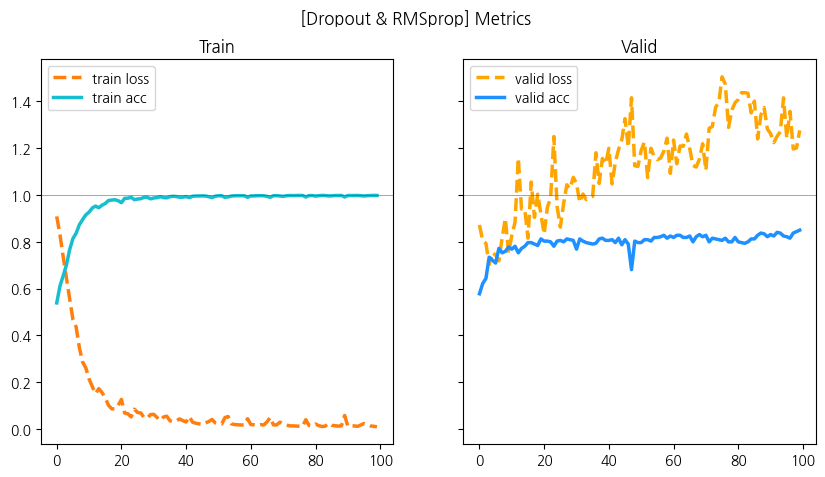

In [61]:
# 1x2 모양의 서브플롯 생성 (y축 공유)
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

# 첫 번째 서브플롯에 그래프 그리기
axes[0].plot(train_loss, label='train loss', linestyle='--', linewidth=2.5, c='tab:orange')
axes[0].plot(train_acc, label='train acc', linewidth=2.5, c='tab:cyan')
axes[0].axhline(y=1, linewidth=0.5, color='r', alpha=0.7)
# axes[0].tick_params(axis='y', which='both', left=True, right=True)  # y축 눈금 표시
axes[0].set_title('Train')
axes[0].legend(loc='upper left')

# 두 번째 서브플롯에 그래프 그리기
axes[1].plot(valid_loss, label='valid loss', linestyle='--', linewidth=2.5, c='orange')
axes[1].plot(valid_acc, label='valid acc', linewidth=2.5, c='dodgerblue')
axes[1].axhline(y=1, linewidth=0.5, color='r', alpha=0.7)
# axes[1].tick_params(axis='y', which='both', left=True, right=True)  # y축 눈금 표시
axes[1].set_title('Valid')
axes[1].legend(loc='upper left')

# 전체 서브플롯에 대한 타이틀 설정
fig.suptitle('[Dropout & RMSprop] Metrics')

# 전체 그림 보여주기
plt.show()

In [62]:
### 모델 저장
torch.save(CLASSIFIER, filename)

In [63]:
### 모델 불러오기
modelname = './model/RMSprop/best_model.pth'
MODEL = torch.load(modelname)

# CLASSIFIER = CLASSIFIER = SentenceClassifier(
#     vocab_size=vocab_size, hidden_dim=hidden_dim, embedding_dim=embedding_dim, n_layers=n_layers
# )
# CLASSIFIER.load_state_dict(filename)

In [64]:
"""pred_texts = ['이건 10년도 더된일인데, 우리 아빠가 겪은 일임 우리 아빠는 차를 차고 음성 백마령터널을 지나가고 있었음 근데 앞에 자전거탄 할아버지가 지나가고있는거임 그래서 놀래서 끼익! 하고 차를 세웠대 뭐지? 하고 다시 봤는데 할아버지는 온데간데없었대']
pred_tokens = [tokenizer.morphs(text, stem=True) for text in pred_texts]
pred_ids = [[token_to_id.get(token, UNK_ID) for token in text] for text in pred_tokens]
pred_ids = pad_sequence(pred_ids, MAX_LENGTH, PAD_ID)
predTS = torch.LongTensor(pred_ids)
MODEL(predTS).argmax().item()"""

"pred_texts = ['이건 10년도 더된일인데, 우리 아빠가 겪은 일임 우리 아빠는 차를 차고 음성 백마령터널을 지나가고 있었음 근데 앞에 자전거탄 할아버지가 지나가고있는거임 그래서 놀래서 끼익! 하고 차를 세웠대 뭐지? 하고 다시 봤는데 할아버지는 온데간데없었대']\npred_tokens = [tokenizer.morphs(text, stem=True) for text in pred_texts]\npred_ids = [[token_to_id.get(token, UNK_ID) for token in text] for text in pred_tokens]\npred_ids = pad_sequence(pred_ids, MAX_LENGTH, PAD_ID)\npredTS = torch.LongTensor(pred_ids)\nMODEL(predTS).argmax().item()"

In [65]:
def predict(model, pred_texts: list):
    # pred_texts 가 list지만, 문장수는 1개.
    label_dict = {0: ['일본', 'JPN'], 1: ['한국', 'KOR'], 2: ['영미권', 'WST']}
    
    pred_tokens = [tokenizer.morphs(text, stem=True) for text in pred_texts]
    pred_ids = [[token_to_id.get(token, UNK_ID) for token in text] for text in pred_tokens]
    pred_ids = pad_sequence(pred_ids, MAX_LENGTH, PAD_ID)
    predTS = torch.LongTensor(pred_ids)
    result = model(predTS).argmax().item()
    
    print(f'이 괴담은 {label_dict[result]} 쪽 입니다.')

In [66]:
predict(MODEL, ['2002년도 제가 군생활을하던 12사단 89포병대대 인제군 천도리 라는곳에서 있었던 일입니다.'])

이 괴담은 ['한국', 'KOR'] 쪽 입니다.


In [67]:
predict(MODEL, ['산 사이에 있는 작은 시골 마을로, 마을 북쪽 끝에는 깎아낸 산이고, 그 산 바로 밑에는 현도(県道)가 있어.'])

이 괴담은 ['일본', 'JPN'] 쪽 입니다.


In [68]:
predict(MODEL, ['1974년 할로윈 밤이었고, 형과 형의 친구들과 함께 트릭 오어 트릿을 하는 중이었다.'])

이 괴담은 ['한국', 'KOR'] 쪽 입니다.


In [69]:
predict(MODEL, ['마을을 떠나고 5마일쯤 가고 있는데 도로공사 유니폼을 입은 여자가 긴 직선도로 한 가운데서 정지 표지판을 들고 서 있었어.'])

이 괴담은 ['일본', 'JPN'] 쪽 입니다.


In [70]:
predict(MODEL, ['주 경계선을 찾자마자 바로 북쪽으로 넘어가서 집에 갔지. 우린 셋 다 지금까지 그 상황을 세세하게 기억하고 있어.'])

이 괴담은 ['영미권', 'WST'] 쪽 입니다.


In [71]:
predict(MODEL, ['친구들이랑 같이 일리노이에서 시카고로 드라이브하던 도중에 타코벨에 들렀어.'])

이 괴담은 ['한국', 'KOR'] 쪽 입니다.


In [72]:
# 학습했던 자료
predict(MODEL, [' 미국에선 매년 50만명이 넘는 사람들이 흔적도 없이 사라지거나 실종되곤 하지. \
                그 확실하진 않은데 말야, 내가 방금... 찾은 것 같아. '])

이 괴담은 ['영미권', 'WST'] 쪽 입니다.
